In [1]:
%matplotlib inline

import cv2
import json
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DATA_FILE = '/home/dennis/projects/wcc/data.npy'
META_FILE = '/home/dennis/projects/wcc/data.json'

In [3]:
with open(DATA_FILE, 'rb') as f:
    use_samples = np.load(f)
    use_probs = np.load(f)
    test_samples = np.load(f)
    test_probs = np.load(f)
with open(META_FILE, 'r') as f:
    metadata = json.load(f)

In [8]:
from tensorflow.keras.utils import Sequence

NOISE_SHAPE = (4000, 4000)


class SampleStore:

    def __init__(self, samples, sample_dims, actuals=None, out_dims=None, noise_scale=None, rotation_limit=None, rotation_prob=0.0, use_flips=None):
        self.samples = samples
        self.sample_dims = sample_dims
        self.actuals = actuals
        self.out_dims = out_dims
        self.noise_scale = noise_scale
        self.noise_mix = None
        self.rotation_limit = rotation_limit
        self.rotation_prob = rotation_prob
        self.use_flips = use_flips
        self.epoch_number = 0

    @staticmethod
    def _rotate_and_clip(image, angle):
        # calculate clipping to drop skewed parts of rotated image
        clip_size = (math.cos(math.radians(angle)) * np.array(image.shape)).astype(np.int16)
        clip_h = min(clip_size[0], image.shape[0])
        clip_w = min(clip_size[1], image.shape[1])
        base_h = (image.shape[0] - clip_h) // 2
        base_w = (image.shape[1] - clip_w) // 2

        # rotate and return clipped image
        image_center = tuple(np.array(image.shape[1::-1]) / 2)
        rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
        result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
        return result[base_h:base_h+clip_h,base_w:base_w+clip_w]

    @staticmethod
    def _random_flip(x, y, axis):
        if np.random.random() >= .5:
            x = np.flip(x, axis)
            if y is not None:
                y = np.flip(y, axis)
        return x, y

    def _format_sample(self, sample, actual=None):
        h, w, d = sample.shape
        x = sample.copy()
        y = None if actual is None else actual.copy()
        if self.noise_mix is not None:

            # mixin noise per channel
            r0 = np.random.randrange(self.noise_mix.shape[0] - h)
            c0 = np.random.randrange(self.noise_mix.shape[1] - w)
            np.moveaxis(x, [2], [0])
            for channel in range(d):
                mixin = self.noise_mix[r0:r0+h,c0:c0+w]
                x[channel] = np.clip(x[channel] + mixin, 0, 255)
            np.moveaxis(x, [0], [2])

        rotation_angle = None
        if self.rotation_limit is not None and self.rotation_limit > 0 and np.random.random() <= self.rotation_prob:

            # get rotation angle, in either direction
            rotation_angle = (np.random.random() * 2 - 1) * self.rotation_limit

            # rotate and clip the image and actual values
            x = self._rotate_and_clip(x, rotation_angle)
            if y is not None:
                y = self._rotate_and_clip(y, rotation_angle)

        # compute random crop of data to input size
        # TODO: bias these values so center of samples won't be overused
        r0, c0 = 0, 0
        r1, c1 = h, w
        if x.shape[1] > r1:
            offset = np.random.randrange(x.shape[1] - r1)
            r0 += offset
            r1 += offset
        if x.shape[2] > c1:
            offset = np.random.randrange(x.shape[2] - c1)
            c0 += offset
            c1 += offset
        x = x[r0:r1, c0:c1]
        if y is not None:
            y = y[r0:r1, c0:c1]

        # randomly flip vertically and  horizontally
        if self.use_flips:
            x, y = self._random_flip(x, y, 0)
            x, y = self._random_flip(x, y, 1)

        # resize output
        if y is not None:
            y = cv2.resize(y, dsize=self.out_dims)
        return x, y

    def _create_noise(self):
        if self.noise_shape is not None and self.noise_scale is not None:
            self.noise_mix = np.random.default_rng().normal(size=self.noise_shape).astype(np.float32) * self.noise_scale

    def reset(self):
        self._create_noise()
        self.epoch_number += 1

    def sample(self, index):
        actual = None if self.actuals is None else self.actuals[index]
        return self._format_sample(self.samples[index], actual)
    
    def sample_count(self):
        return len(self.samples)


class SampleSequence(Sequence):

    def __init__(self, sample_store, batch_size, is_train=True):
        self.batch_size = batch_size
        self.sample_store = sample_store
        self.is_train = is_train
        self.sample_order = np.random.permutation(sample_store.sample_count())
        self.on_epoch_end()

    def __len__(self):
        return len(self.sample_store.sample_count()) // self.batch_size

    def on_epoch_end(self):
        np.random.default_rng().shuffle(self.sample_order)

    def __getitem__(self, idx):
        indices = self.sample_order[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_x, batch_y = zip(*([self.sample_store.sample(i) for i in indices]))
        if self.is_train:
            return batch_x, batch_y
        else:
            return batch_x

In [9]:
actuals = (use_probs * 255).astype(np.uint8)
store = SampleStore(use_samples, (800, 800), actuals, (400, 400), .1, 30, .5, True)
sequence = SampleSequence(store, 4)

In [10]:
index = 0

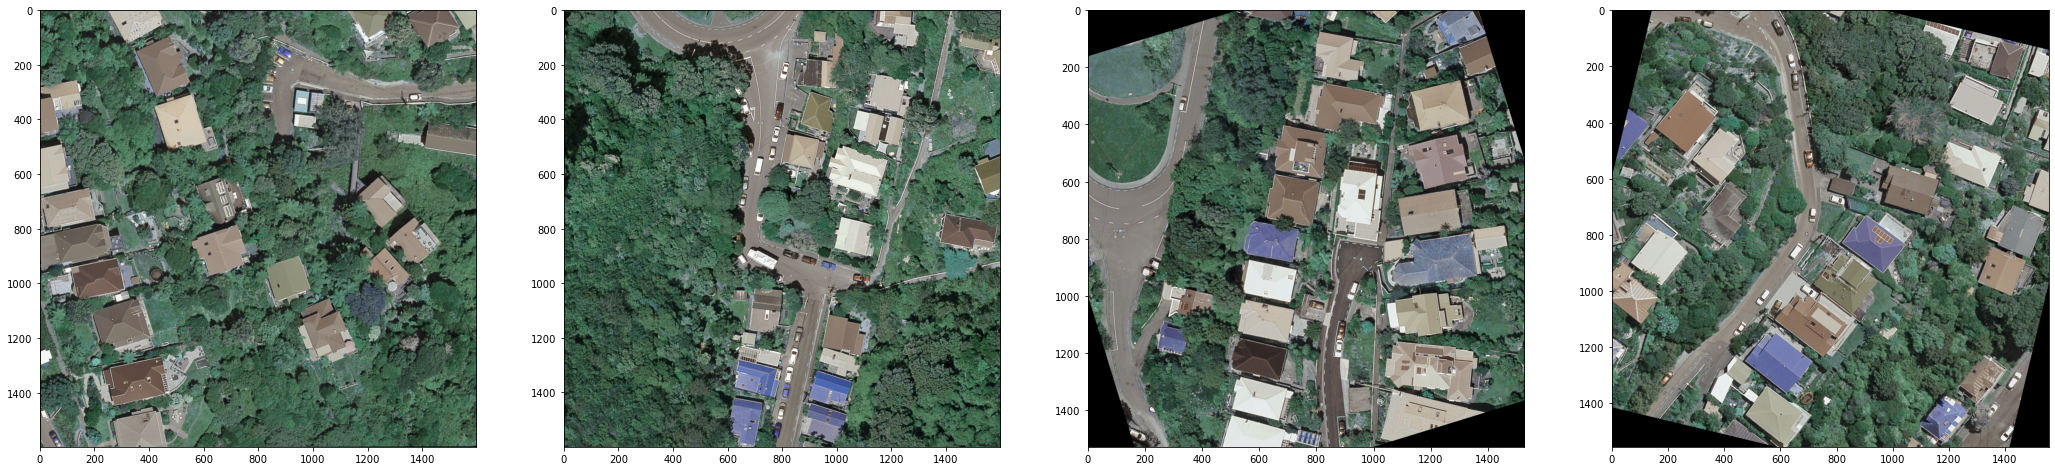

In [17]:
index = index + 1
fig, ax = plt.subplots(1, 4, figsize=(36,12))
batch_x, batch_y = sequence.__getitem__(index)
ax[0].imshow(batch_x[0])
ax[1].imshow(batch_x[1])
ax[2].imshow(batch_x[2])
ax[3].imshow(batch_x[3])
plt.show()

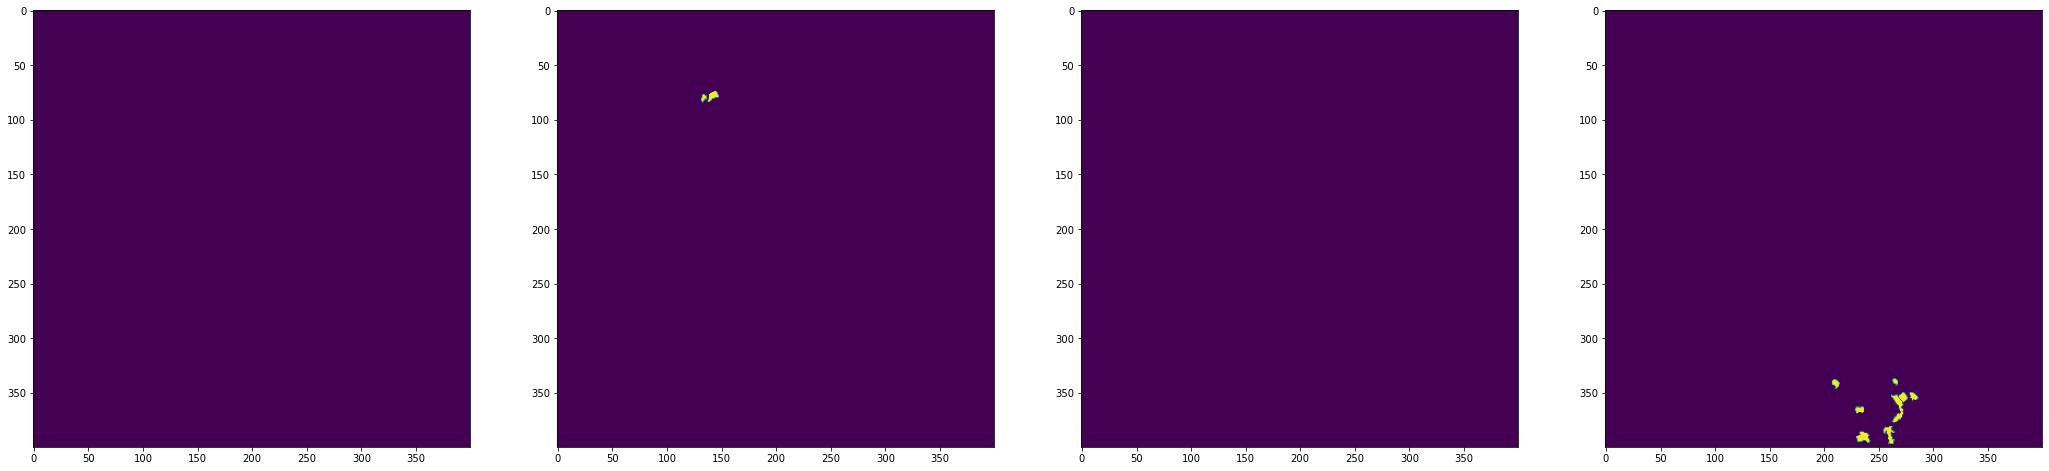

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(36,12))
ax[0].imshow(batch_y[0])
ax[1].imshow(batch_y[1])
ax[2].imshow(batch_y[2])
ax[3].imshow(batch_y[3])
plt.show()

In [19]:
batch_y[0].shape

(400, 400)